#### Cross Inference

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import copy
import magic
from torchvision.utils import save_image
import torch.nn.functional as F
from barbar import Bar
import cv2
from sklearn.metrics import accuracy_score

In [2]:
# set gpu
device = torch.device("cuda")

# load data
data_dir = '../../../scratch/zwinzurk/wild/datasets'

# Test at same location
#name = 'lila/KAR_S1/KAR_S1_'

# Test at different location
name = 'lila/ENO_S1/ENO_S1_train'
#name = 'lila/MTZ_S1/MTZ_S1_'
#name = 'lila/KRU_S1/KRU_S1_'

# inference batch size
batch_size = 192

In [3]:
# plot training loss
#df = pd.read_csv('reports/KAR_S1_detection_finetune_densenet121_01.txt', sep='\t')
df = pd.read_csv('reports/MTZ_S1_detection_scratch_resnet50_01.txt', sep='\t')

In [4]:
df.head()

,epoch,training_loss,training_acc,valid_loss,valid_acc
0,1,0.812216,0.689931,0.455923,0.780904
1,2,0.405340,0.823442,0.360418,0.845695
2,3,0.322367,0.866489,0.297289,0.884910
3,4,0.286135,0.884070,0.322578,0.858483
4,5,0.255768,0.899094,0.284334,0.896846


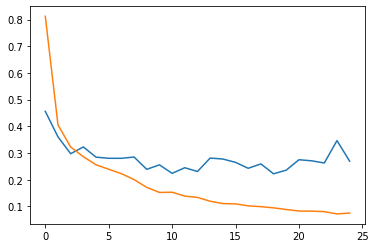

In [5]:
import matplotlib.pyplot as plt
plt.plot(df['valid_loss'])
plt.plot(df['training_loss'])
plt.show()

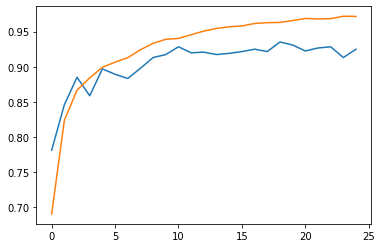

In [6]:
import matplotlib.pyplot as plt
plt.plot(df['valid_acc'])
plt.plot(df['training_acc'])
plt.show()

In [7]:
# test set data loader
test_data = magic.CameraTrapsDataset(csv_file=f'{name}.csv', root_dir=data_dir)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)
# class names
class_names = ['negative', 'positive']

In [8]:
# load model and best training weights
#model = models.densenet121(pretrained=False)
model = models.resnet50(pretrained=False)
model.classifier = nn.Linear(1024, 2)
model.load_state_dict(torch.load('MTZ_S1_detection_scratch_resnet50_01.pth'))
parallel_model = torch.nn.DataParallel(model).to(device)

In [9]:
# forward pass on test set
label_list = []
pred_list = []
img_list = []

with torch.no_grad():
    for idx, data in enumerate(Bar(test_dataloader)):
        inputs = Variable(data.get('image')).to(device)
        target = Variable(data.get('class')).to(device)
        imagepaths = data.get('imagepath')
        output = parallel_model(inputs)
        _, preds = torch.max(output, 1)
        
        label_list.append(target)
        pred_list.append(preds)
        img_list.extend(imagepaths)
        
Y = label_list[0]
Y_hat = pred_list[0]
for i in range(1, len(label_list)):
    Y = torch.cat((Y, label_list[i]), dim=0)
    Y_hat = torch.cat((Y_hat, pred_list[i]), dim=0)
        
Y = Y.cpu().numpy()
Y_hat = Y_hat.cpu().numpy()
accuracy_score(Y, Y_hat)

16357/16357: [===============================>] - ETA 22.8sss


0.571926392370239

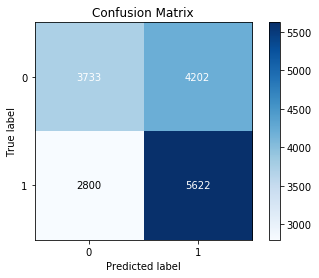

In [10]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(Y, Y_hat)
plt.show()

In [11]:
# index misclassified images
missed = {}
count = 0
for i in range(len(Y)):
    if Y[i] != Y_hat[i]:
        missed.update({count:i})
        count += 1
print(f'Photos in Test Set: {len(Y)}')
print(f'Photos Missed: {len(missed)}')

Photos in Test Set: 16357
Photos Missed: 7002


In [ ]:
# Misclassification Report
print('Misclassification Report')

for i in range(len(missed)):
    index = missed.get(i)
    path = img_list[index]
    reverse_class_map = {1:'positive', 0:'negative'}

    # plot images
    print(f'Ground Truth: {reverse_class_map.get(Y[index])}')
    print(f'Prediction: {reverse_class_map.get(Y_hat[index])}')
    print(f'{path}')
    image = cv2.imread(path)
    plt.figure(figsize = (12,12))
    plt.imshow(image, cmap=None, interpolation='None', aspect=None)
    #plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    print()